PCA based on scikit-allel, with some code taken from http://alimanfoo.github.io/2015/09/28/fast-pca.html 

In [1]:
#Initial configuration, probably overkill in imports.
import sys, os, re
import numpy as np
import allel
import zarr
import dask
import numcodecs
import warnings
from pathlib import Path

#os.environ["MODIN_ENGINE"] = "ray"

#import modin.pandas as pd
import pandas as pd

%matplotlib widget
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")

In [2]:
meta_data_samples = pd.read_table("../data/meta_data_samples.txt", sep = " ")
meta_data_samples

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index
0,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,0
1,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,1
2,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,2
3,4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,3
4,5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,4
...,...,...,...,...,...,...,...,...,...,...,...,...
155,212,PD_0789,34417_BZ11064,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,155
156,213,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,156
157,214,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,157
158,215,PD_0792,34420_BZ11067,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,158


In [3]:
#Opening the zarr data
callset = zarr.open_group('/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/callset.zarr', mode='r')
callset.tree(expand=False)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='chr1', nodes=(Node(disabled=True, n…

In [34]:
#Function to offset a legend to the right, as well as making it able to save with savefig.
def offset_legend(fig):
    ax = fig.add_subplot(111)
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='best', bbox_to_anchor=(1,1))
    return lgd

In [5]:
#Functions from http://alimanfoo.github.io/2015/09/28/fast-pca.html 
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn


In [6]:
#Setting up a function to do a PCA for a specific input
def pruning_and_pca(chrom, IDs, subsampling_n, size, n_iter):
    print("Investigating {} with {} individuals".format(chrom, len(IDs)))
    gt_zarr = allel.GenotypeChunkedArray(callset["{}/calldata/GT".format(chrom)]) #Loading in the zarr dataset
    gt_zarr = gt_zarr.take(IDs, axis=1)
    ac = gt_zarr.count_alleles()[:] #Allele counts for each pos
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filtering for biallelic 
    #and at least two individuals in the alt state
    gf = gt_zarr.compress(flt, axis=0) #Applying filter
    gn = gf.to_n_alt() #Transform genotype to number of non-ref alleles
    if subsampling_n > len(gn):
        subsampling_n = len(gn)-1
    vidx = np.random.choice(gn.shape[0], subsampling_n, replace=False) #Random subsampling
    vidx.sort()
    gnr = gn.take(vidx, axis=0) #Applying the random subsample
    gnu = ld_prune(gnr, size=size, step=200, threshold=.1, n_iter=n_iter) #Pruning based on LD
    if len(gnu) > 150000:
        print("Too large dataset for pca")
        return "Too large dataset for pca"
    gnu = gnu[:] #Taking it out of chunked storage
    coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson') #Running the pca
    #The plotting solution in the example is inflexible, so I will try to make it through seaborn.
    pca_df = pd.DataFrame()
    c_transposed = coords1.transpose()
    for i in range(len(c_transposed)):
        pc = "pc{}".format(i+1)
        pca_df[pc] = c_transposed[i]
    pca_df_meta = pd.concat([pca_df, meta_data_samples.iloc[IDs].reset_index()], axis = 1, ignore_index=False)
    return pca_df_meta

In [7]:
IDs = meta_data_samples.callset_index.values
pca_df = pruning_and_pca("chrX", IDs, 3000000, 500, 2)

Investigating chrX with 160 individuals
iteration 1 retaining 343333 removing 2016296 variants
iteration 2 retaining 113970 removing 229363 variants


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


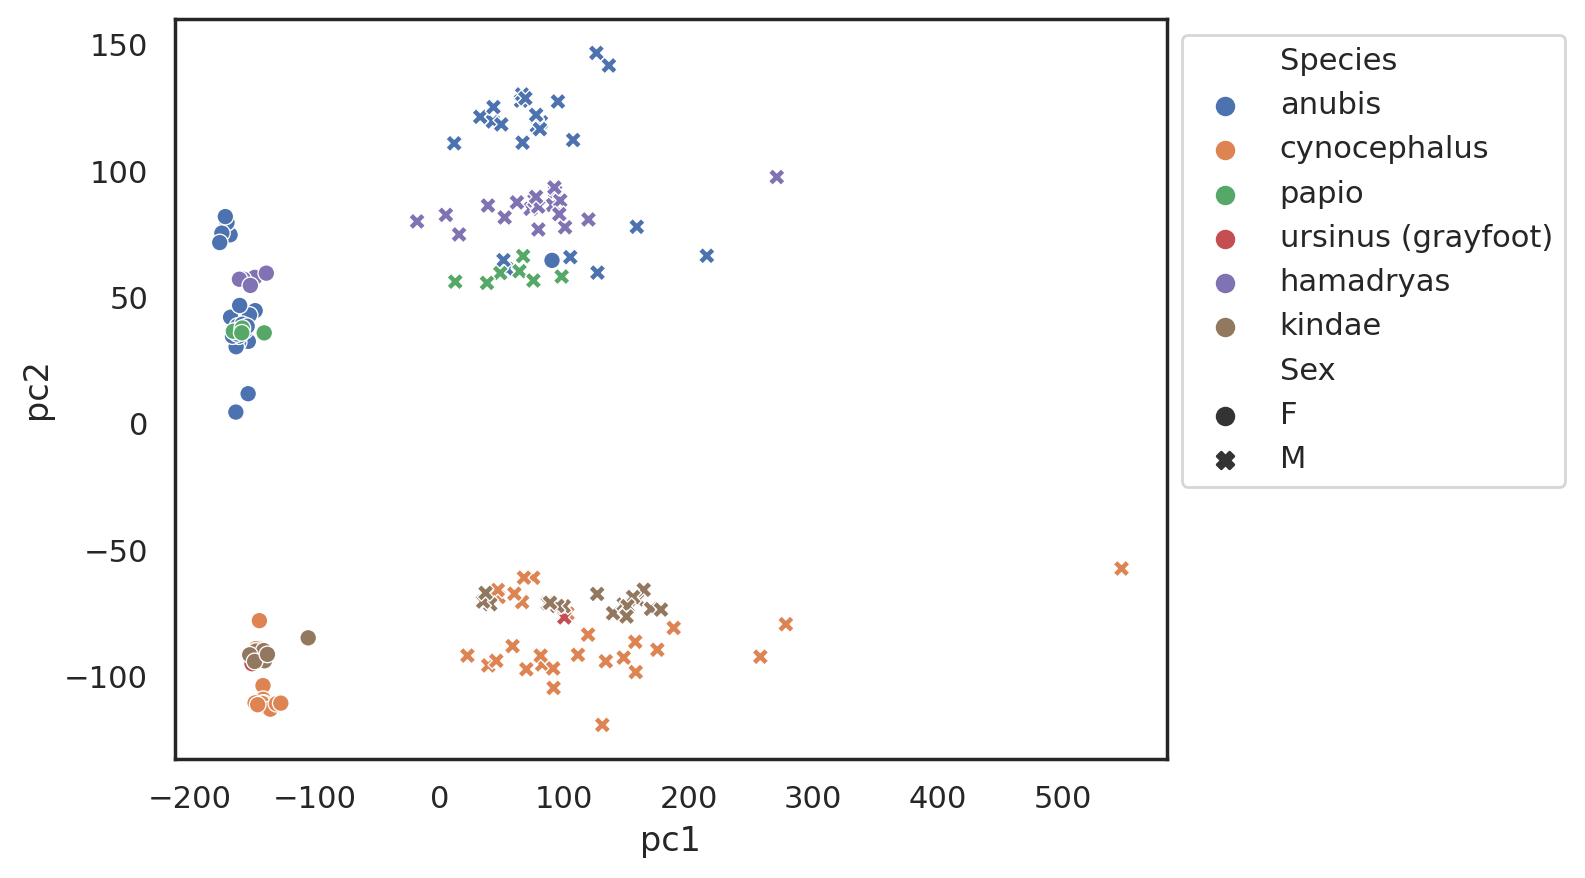

In [8]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)
fig_males.savefig("../results/pca_plot_origin", bbox_extra_artists=[lgd], bbox_inches='tight')
fig_males

In [32]:
IDs = meta_data_samples.loc[(meta_data_samples.Sex == "F") & (meta_data_samples.PGDP_ID != "PD_0202")].callset_index.values
pca_df = pruning_and_pca("chrX", IDs, 3000000, 500, 2) #Make sure that enough variants are removed.

Investigating chrX with 63 individuals
iteration 1 retaining 105115 removing 1525828 variants
iteration 2 retaining 17013 removing 88102 variants


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


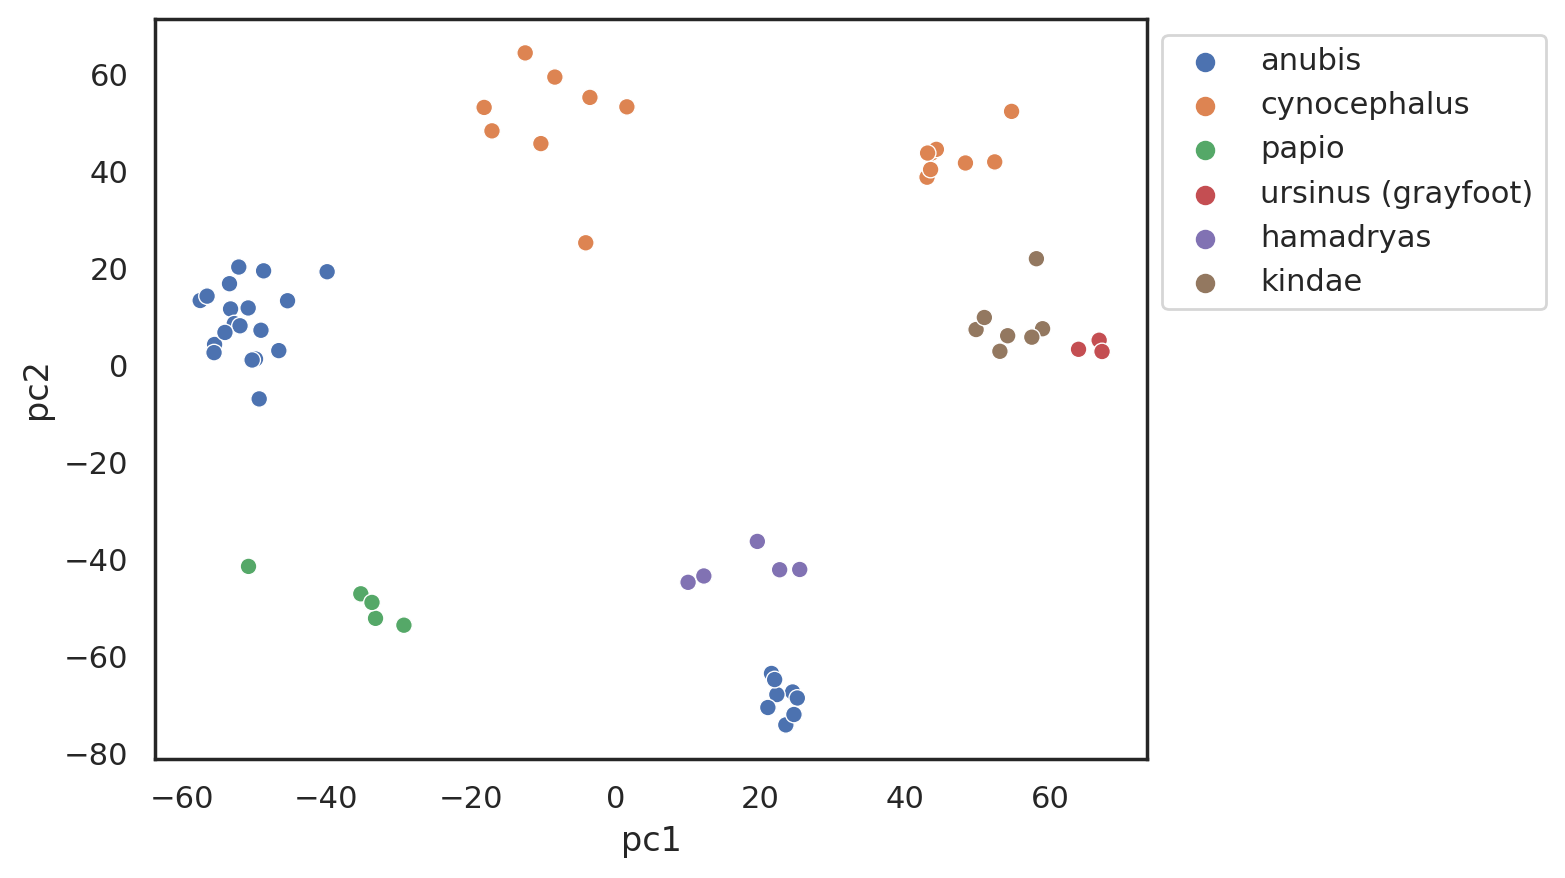

In [35]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species")
fig1 = scatter_sns.get_figure()
lgd = offset_legend(fig1)
fig1.savefig("../results/pca_plot_species", bbox_extra_artists=[lgd], bbox_inches='tight')
fig1

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


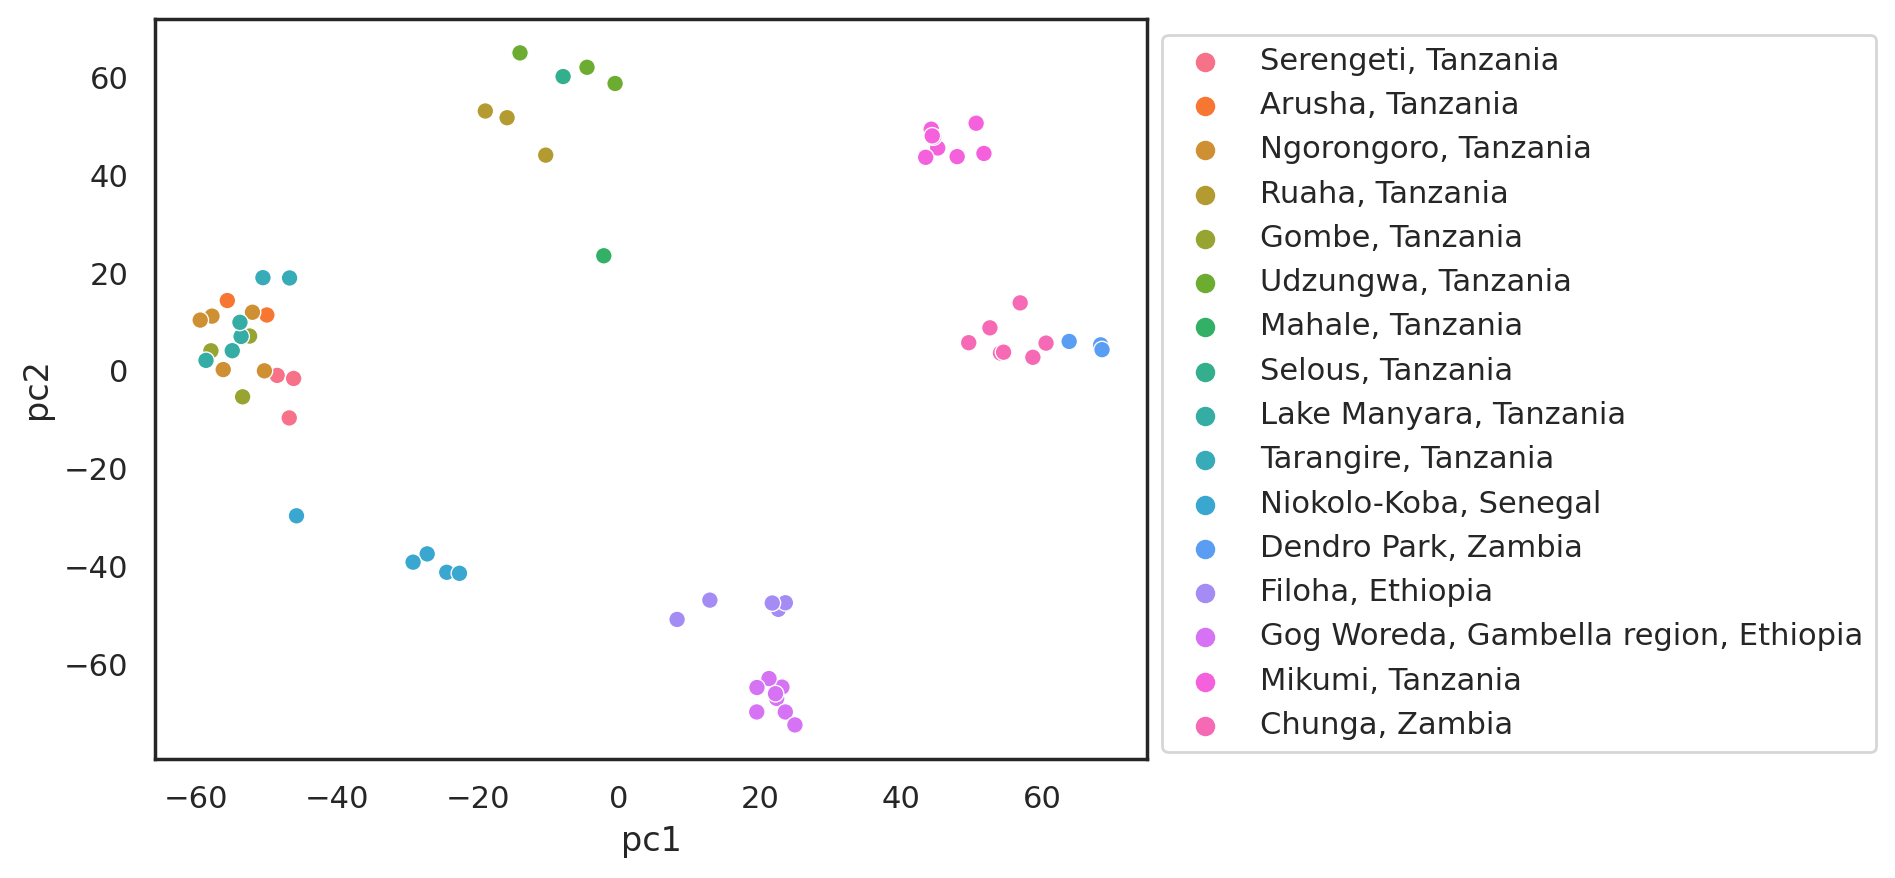

In [11]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Origin")
fig2 = scatter_sns.get_figure()
lgd = offset_legend(fig2)
fig2.savefig("../results/pca_plot_origin", bbox_extra_artists=[lgd], bbox_inches='tight')
fig2

In [12]:
#Only taking 10 individuals per Species.
females = meta_data_samples.loc[(meta_data_samples.Sex == "F") & (meta_data_samples.PGDP_ID != "PD_0202")]
IDs = []

for species in meta_data_samples.Species.unique():
    species_IDs = females.loc[females.Species == species]
    n = min(3, len(species_IDs))
    print("Taking {}, which are of speices {}".format(n, species))
    IDs.extend(np.random.choice(species_IDs.callset_index.values, n, replace=False))
pca_df = pruning_and_pca("chrX", IDs, 3000000, 250, 3)

Taking 3, which are of speices anubis
Taking 3, which are of speices cynocephalus
Taking 3, which are of speices papio
Taking 3, which are of speices ursinus (grayfoot)
Taking 3, which are of speices hamadryas
Taking 3, which are of speices kindae
Investigating chrX with 18 individuals
iteration 1 retaining 47633 removing 973522 variants
iteration 2 retaining 3787 removing 43846 variants
iteration 3 retaining 764 removing 3023 variants


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


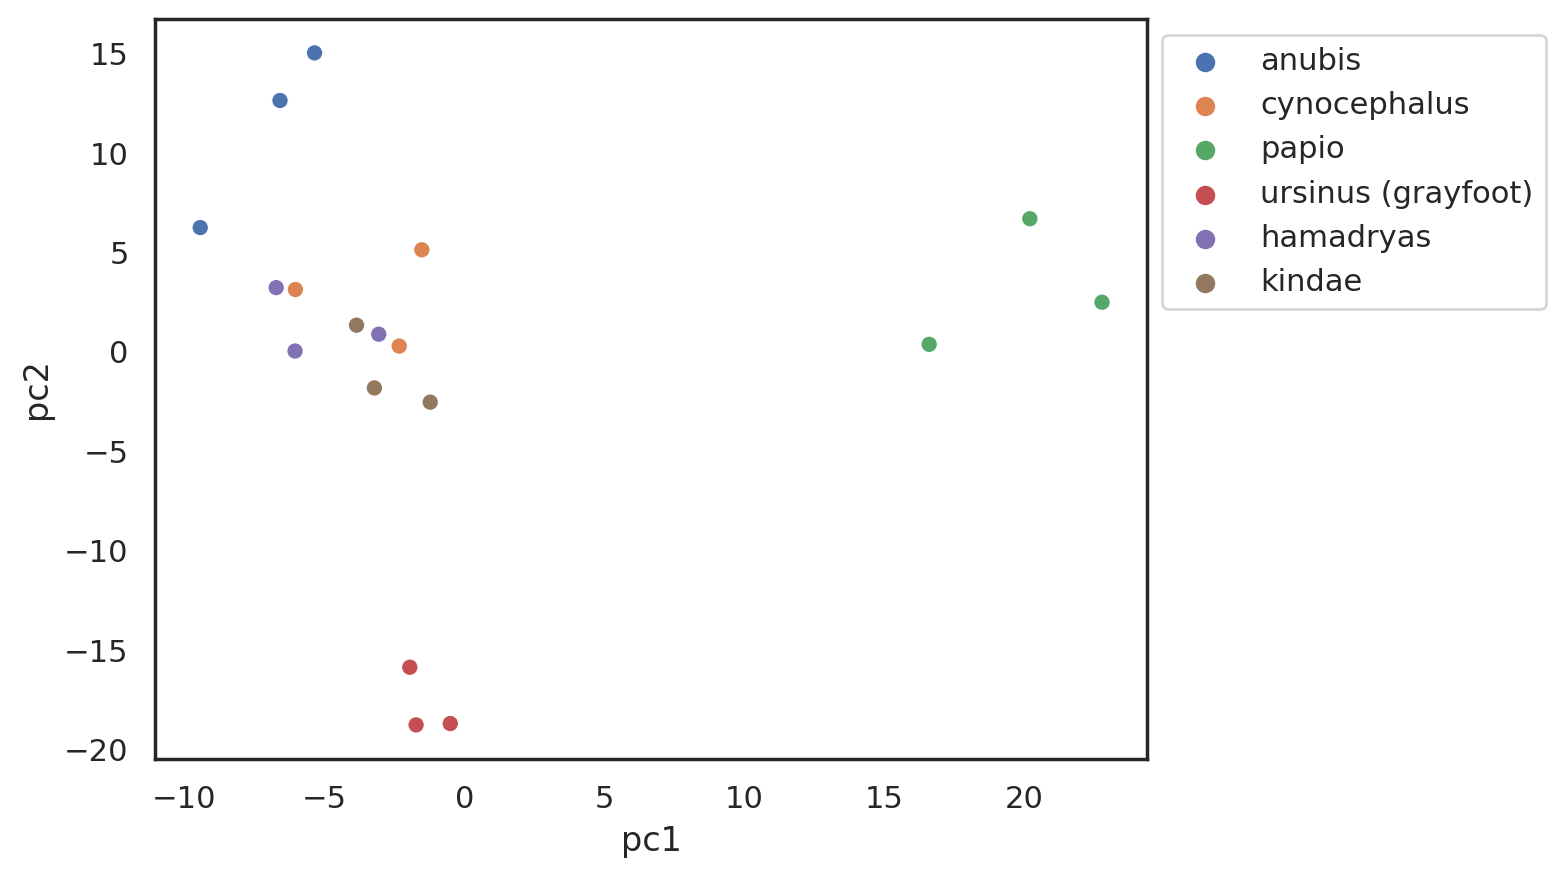

In [13]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species")
fig3 = scatter_sns.get_figure()
lgd = offset_legend(fig3)
fig3.savefig("../results/pca_plot_species_subset", bbox_extra_artists=[lgd], bbox_inches='tight')
fig3

In [26]:
#Only taking 4 individuals per Origin.
females = meta_data_samples.loc[(meta_data_samples.Sex == "F") & (meta_data_samples.PGDP_ID != "PD_0202")]
IDs = []

for origin in meta_data_samples.Origin.unique():
    origin_IDs = females.loc[females.Origin == origin]
    species = origin_IDs.Species.values
    n = min(4, len(origin_IDs))
    if len(species) > 0:
        print("Taking {} from origin {}, which are of species {}".format(n, origin, species[0]))
    IDs.extend(np.random.choice(origin_IDs.callset_index.values, n, replace=False))

Taking 3 from origin Serengeti, Tanzania, which are of species anubis
Taking 2 from origin Arusha, Tanzania, which are of species anubis
Taking 4 from origin Ngorongoro, Tanzania, which are of species anubis
Taking 3 from origin Ruaha, Tanzania, which are of species cynocephalus
Taking 3 from origin Gombe, Tanzania, which are of species anubis
Taking 3 from origin Udzungwa, Tanzania, which are of species cynocephalus
Taking 1 from origin Mahale, Tanzania, which are of species cynocephalus
Taking 1 from origin Selous, Tanzania, which are of species cynocephalus
Taking 4 from origin Lake Manyara, Tanzania, which are of species anubis
Taking 2 from origin Tarangire, Tanzania, which are of species anubis
Taking 4 from origin Niokolo-Koba, Senegal, which are of species papio
Taking 3 from origin Dendro Park, Zambia, which are of species ursinus (grayfoot)
Taking 4 from origin Filoha, Ethiopia, which are of species hamadryas
Taking 4 from origin Gog Woreda, Gambella region, Ethiopia, which a

In [27]:
pca_df = pruning_and_pca("chrX", IDs, 3000000, 250, 3)

Investigating chrX with 49 individuals
iteration 1 retaining 138668 removing 1352293 variants
iteration 2 retaining 25305 removing 113363 variants
iteration 3 retaining 7327 removing 17978 variants


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


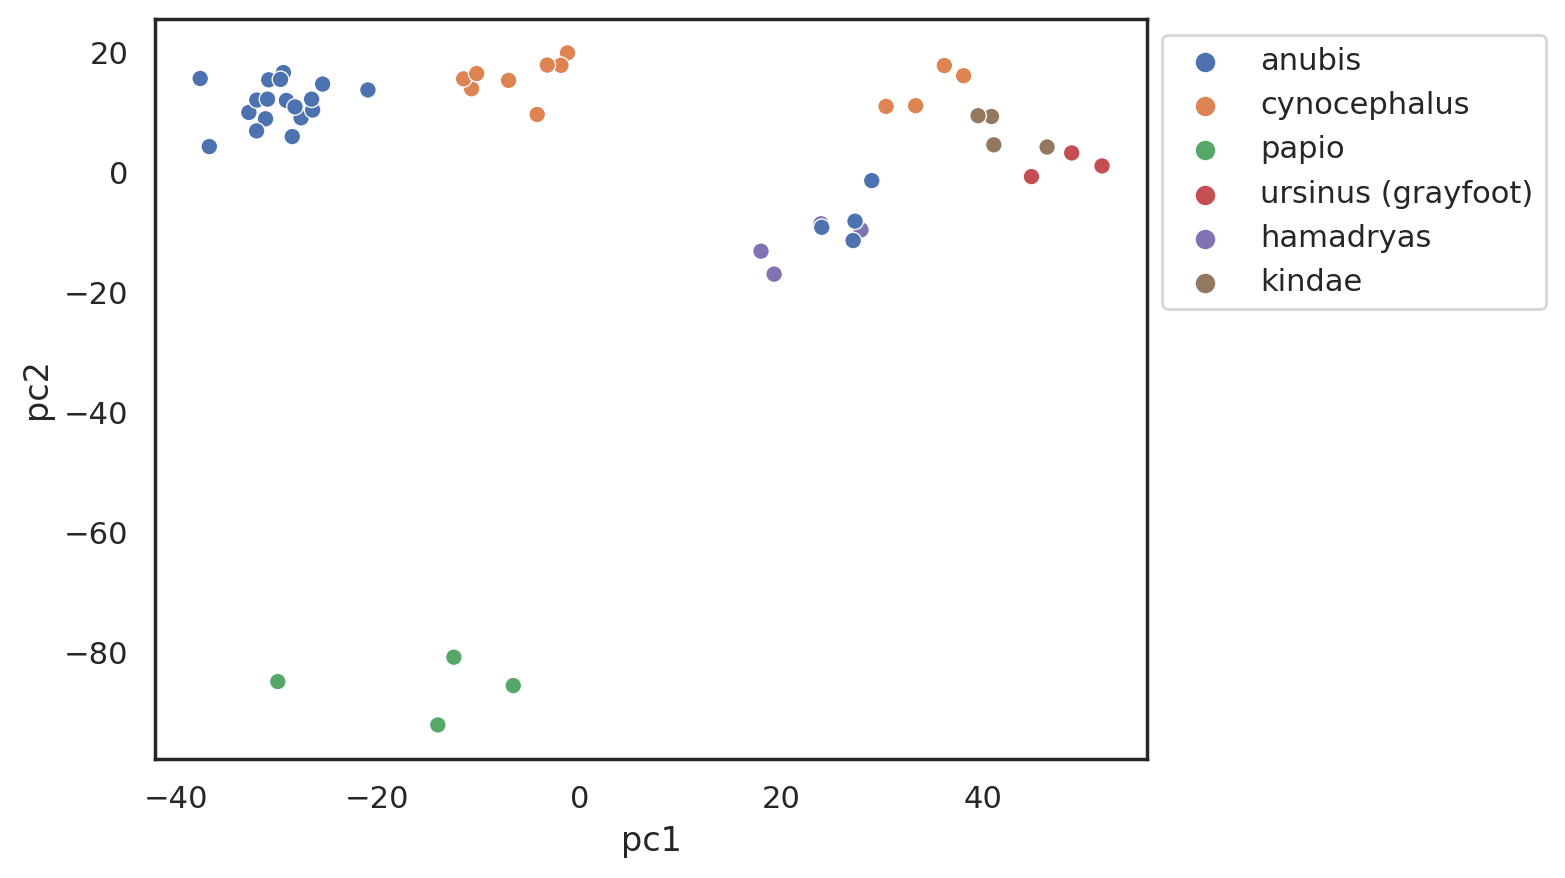

In [28]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species")
fig4 = scatter_sns.get_figure()
lgd = offset_legend(fig4)
fig4.savefig("../results/pca_plot_4_per_origin_species", bbox_extra_artists=[lgd], bbox_inches='tight')
fig4

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


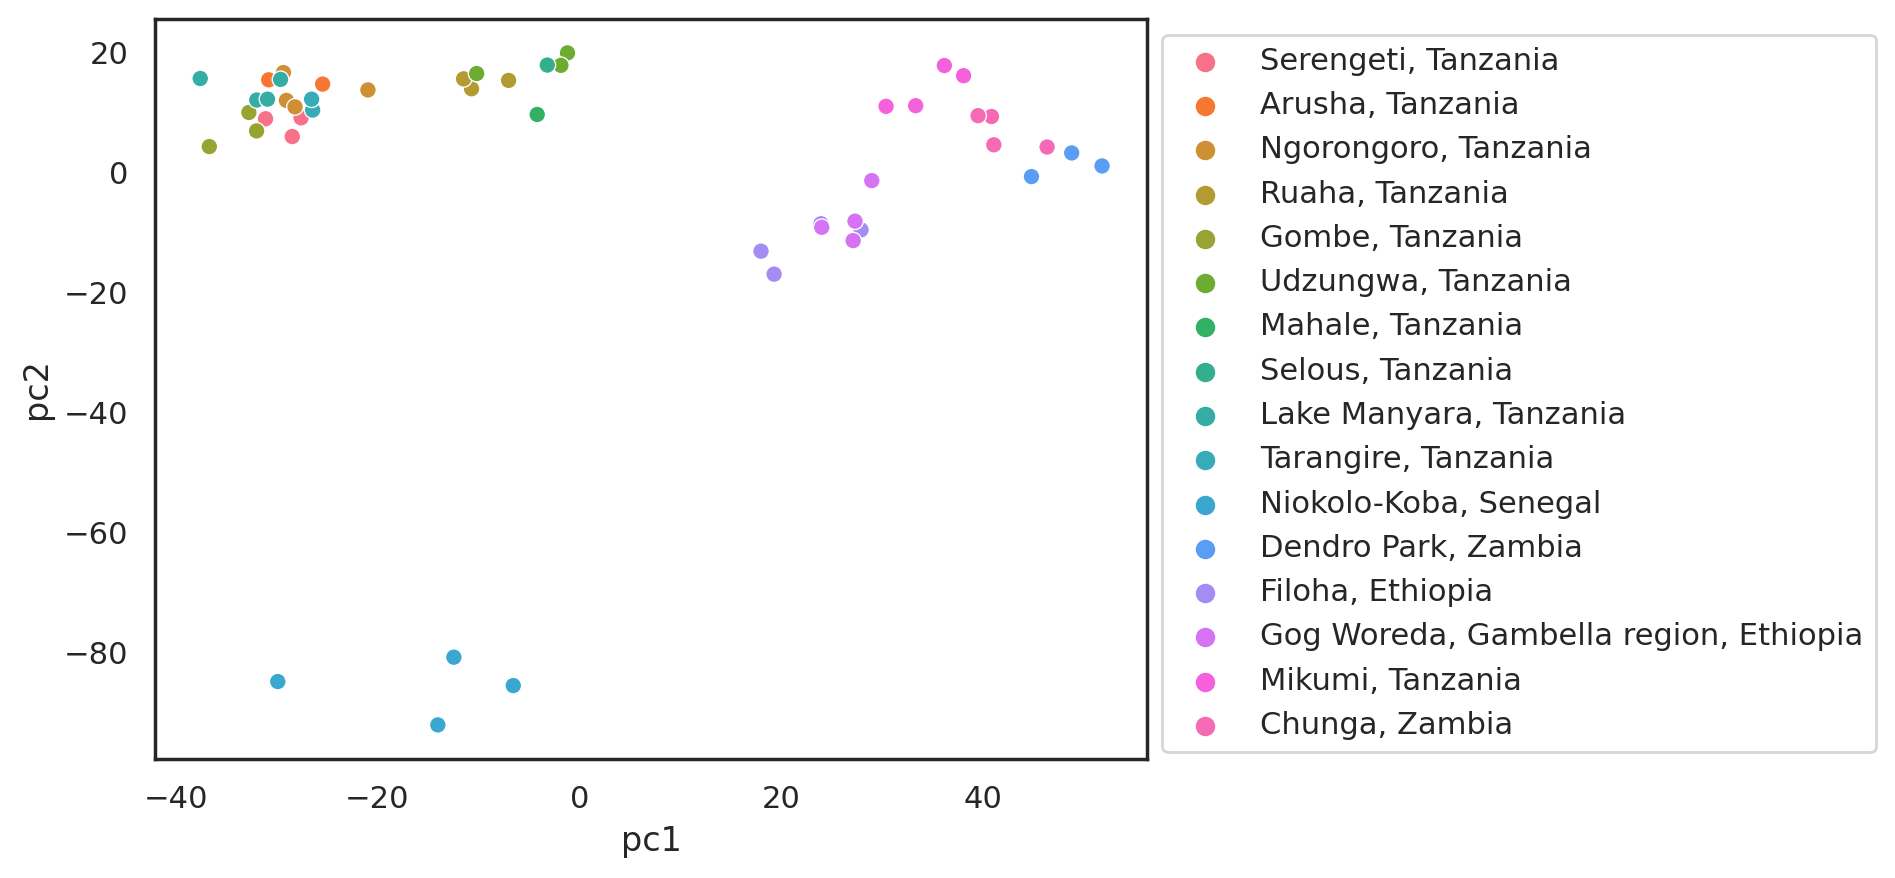

In [29]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Origin")
fig5 = scatter_sns.get_figure()
lgd = offset_legend(fig5)
fig5.savefig("../results/pca_plot_4_per_origin", bbox_extra_artists=[lgd], bbox_inches='tight')
fig5

In [18]:
#Only taking 10 individuals per species, here on chr7 and with males.
IDs = []

for species in meta_data_samples.Species.unique():
    species_IDs = meta_data_samples.loc[meta_data_samples.Species == species]
    n = min(10, len(species_IDs))
    print("Taking {} from species {}".format(n, species))
    IDs.extend(np.random.choice(species_IDs.callset_index.values, n, replace=False))

Taking 10 from species anubis
Taking 10 from species cynocephalus
Taking 10 from species papio
Taking 4 from species ursinus (grayfoot)
Taking 10 from species hamadryas
Taking 10 from species kindae


In [19]:
pca_df = pruning_and_pca("chr7", IDs, 3000000, 250, 2)

Investigating chr7 with 54 individuals
iteration 1 retaining 252195 removing 2449554 variants
iteration 2 retaining 42891 removing 209304 variants


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


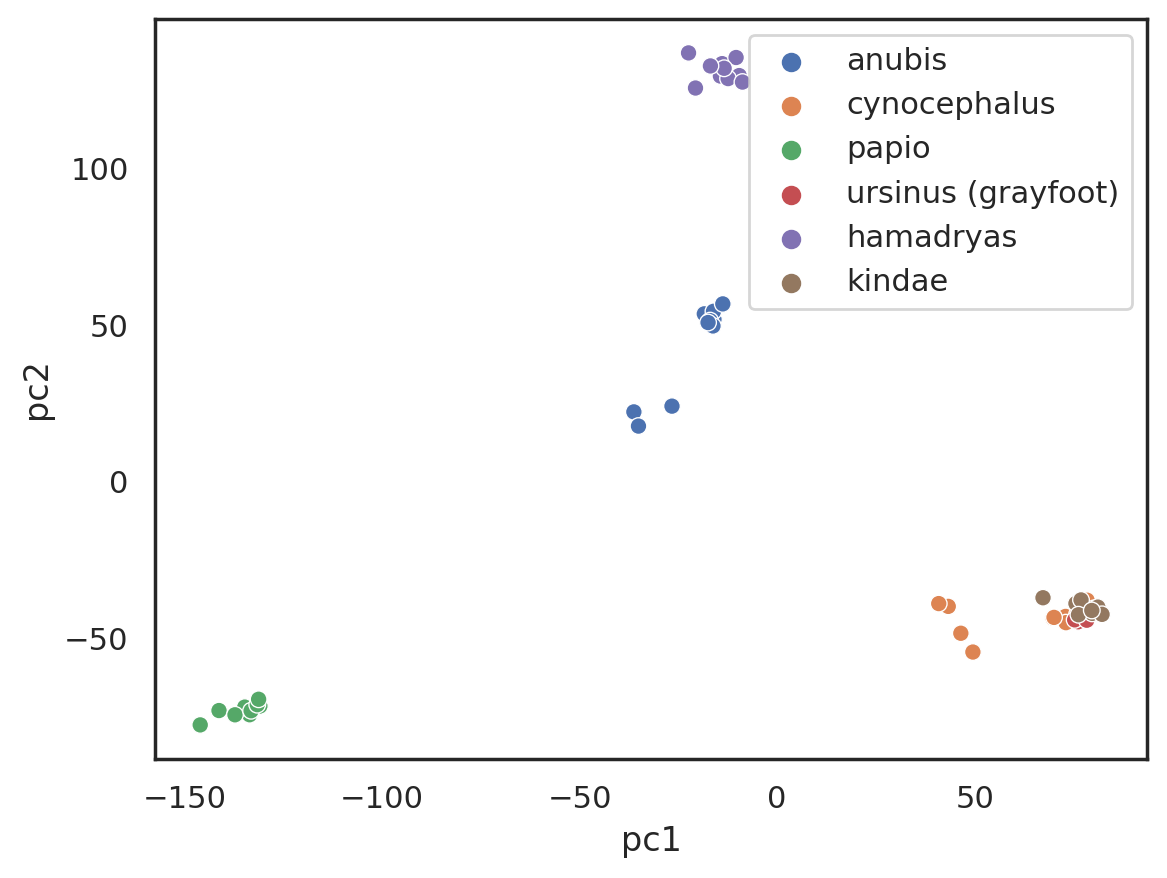

In [20]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species")
fig6 = scatter_sns.get_figure()
lgd = offset_legend(fig6)
fig6.savefig("../results/pca_plot_species_10_IDs_chr7", bbox_extra_artists=[lgd], bbox_inches='tight')
fig6

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


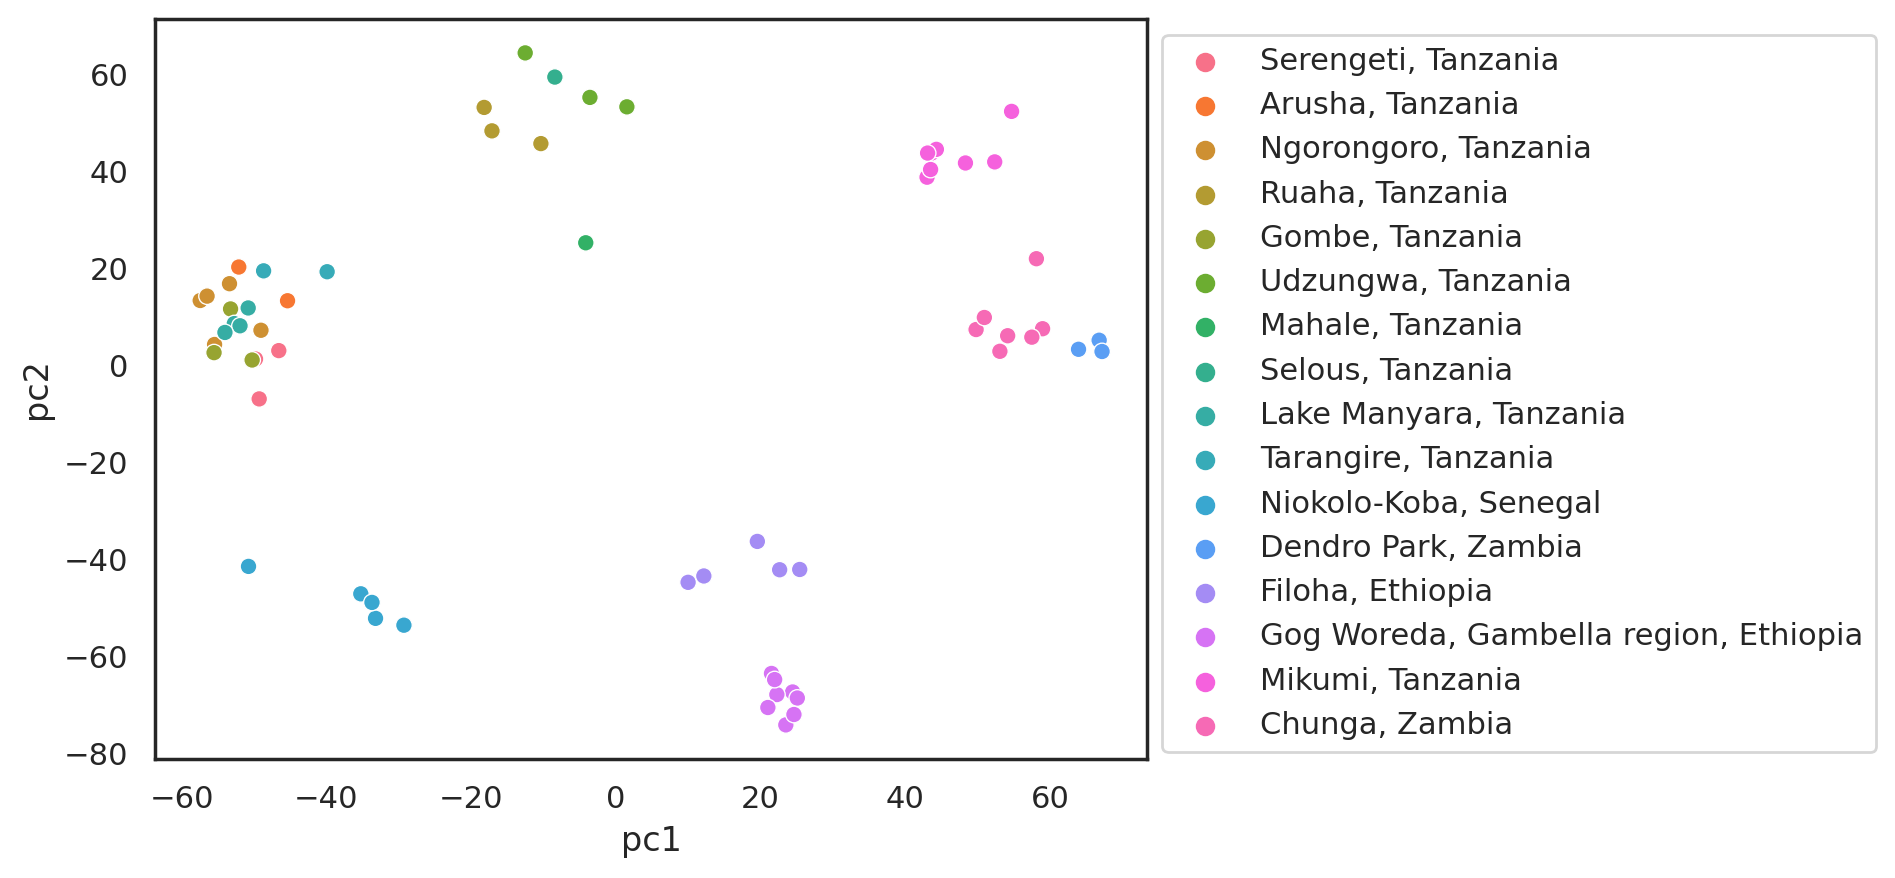

In [36]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Origin")
fig7 = scatter_sns.get_figure()
lgd = offset_legend(fig7)
fig7.savefig("../results/pca_plot_origin_10_IDs_chr7", bbox_extra_artists=[lgd], bbox_inches='tight')
fig7

In [30]:
print("github test")

github test
